In [1]:
import jax.numpy as jnp
import plotly.express as px
from plotly.subplots import make_subplots
import jax
import numpy as np
from datasets import mnist
import plotly.graph_objects as go

import copy

In [2]:
train_images, train_labels, test_images, test_labels = mnist()

train_images = train_images.astype(jnp.float32)
test_images = test_images.astype(jnp.float32)

train_labels = jnp.asarray(train_labels, dtype=jnp.int32)
test_labels = jnp.asarray(test_labels, dtype=jnp.int32)

In [3]:
def visualize_images(images_tensor, w=28, h=28, col_wrap=5):
    
    img = images_tensor.reshape(-1, w, h)
    
    fig = px.imshow(img[:, :, :], binary_string=False, facet_col=0, facet_col_wrap=col_wrap)
    
    item_map={f'{i}':"" for i, key in enumerate(range(img.shape[0]))}
    fig.for_each_annotation(lambda a: a.update(text=item_map[a.text.split("=")[1]])) 
    
    fig.show()

In [5]:
net_parameters = {
    'w0' : np.random.randn(256, 784) * 0.1,
    'w1' : np.random.randn(256, 256) * 0.1,
    'w2' : np.random.randn(256, 256) * 0.1,
    'w3' : np.random.randn(10, 256) * 0.1,
}

In [6]:
def ReLU(x):
    return jnp.maximum(0,x)

def forward(parameters, x):
    x = x.T
    x = parameters['w0'] @ x
    x = ReLU(x)
    x = parameters['w1'] @ x
    x = ReLU(x)
    x = parameters['w2'] @ x
    x = ReLU(x)
    x = parameters['w3'] @ x
    x = x.T
    return x

In [7]:
def loss(parameters, x, y):
    out = forward(parameters, x)
    out = jax.nn.softmax(out)
    _loss = -(y * jnp.log(out)).sum(axis=-1).mean()
    return _loss

loss(net_parameters, test_images, test_labels)

Array(2.731128, dtype=float32)

In [8]:
(forward(net_parameters, train_images).argmax(axis=-1) == train_labels.argmax(axis=-1)).mean()

Array(0.06178333, dtype=float32)

In [9]:
grad_loss = jax.grad(loss)
lr = 0.1

# keep track of all the previous gradients
grad_history = []

# keep track of all the previous parameters
parameter_deltas = []

for epoch in range(100):
    
    p_grad = grad_loss(net_parameters, train_images, train_labels)
    grad_history.append(p_grad)
    
    net_parameters['w0'] -= lr * p_grad['w0']
    net_parameters['w1'] -= lr * p_grad['w1']
    net_parameters['w2'] -= lr * p_grad['w2']
    net_parameters['w3'] -= lr * p_grad['w3']

    # record the changes that were made to the parameters for analysis
    parameter_delta_vector = np.concatenate((
        -lr * p_grad['w0'].flatten(),
        -lr * p_grad['w1'].flatten(),
        -lr * p_grad['w2'].flatten(),
        -lr * p_grad['w3'].flatten()
    ))
    parameter_deltas.append(parameter_delta_vector)



    print(f"epoch {epoch}")
    print(f"validation loss: {loss(net_parameters, test_images, test_labels)}")
    print(f"train loss: {loss(net_parameters, train_images, train_labels)}")
    acc = (forward(net_parameters, train_images).argmax(axis=-1) == train_labels.argmax(axis=-1)).mean()
    print(f"accuracy: {acc}")
    print("\n")

epoch 0
validation loss: 2.277862548828125
train loss: 2.276801347732544
accuracy: 0.20038333535194397


epoch 1
validation loss: 1.9986860752105713
train loss: 2.0062105655670166
accuracy: 0.28600001335144043


epoch 2
validation loss: 1.8096214532852173
train loss: 1.8151549100875854
accuracy: 0.3808833360671997


epoch 3
validation loss: 1.7291929721832275
train loss: 1.7464510202407837
accuracy: 0.4345833361148834


epoch 4
validation loss: 1.49941086769104
train loss: 1.5121557712554932
accuracy: 0.5228833556175232


epoch 5
validation loss: 1.4020278453826904
train loss: 1.424275279045105
accuracy: 0.5604666471481323


epoch 6
validation loss: 1.3016060590744019
train loss: 1.3177744150161743
accuracy: 0.5866666436195374


epoch 7
validation loss: 1.2220079898834229
train loss: 1.247183084487915
accuracy: 0.609499990940094


epoch 8
validation loss: 1.157178282737732
train loss: 1.175179362297058
accuracy: 0.6294500231742859


epoch 9
validation loss: 1.0745911598205566
train los

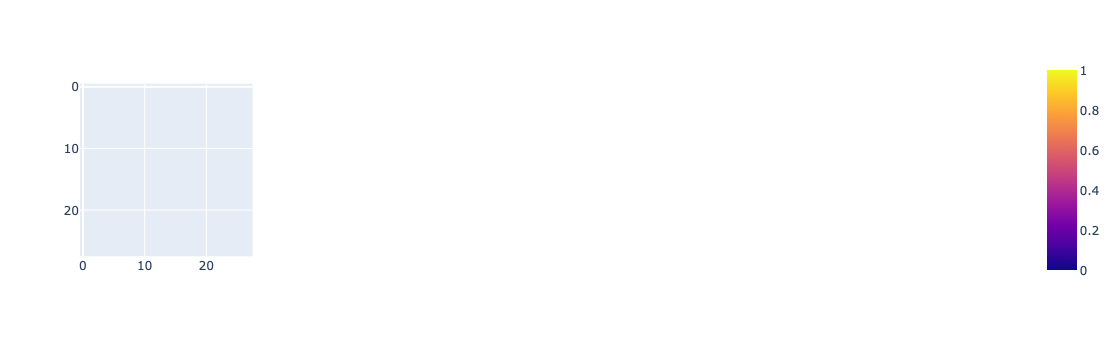

Array([ 0.34763533, -3.1584437 ,  1.6465373 ,  0.7349794 , -0.6372952 ,
       -0.7725915 , -3.224408  ,  9.081954  , -0.8517007 ,  2.2727547 ],      dtype=float32)

In [10]:
im = 0
visualize_images(test_images[im])
forward(net_parameters, test_images[im])

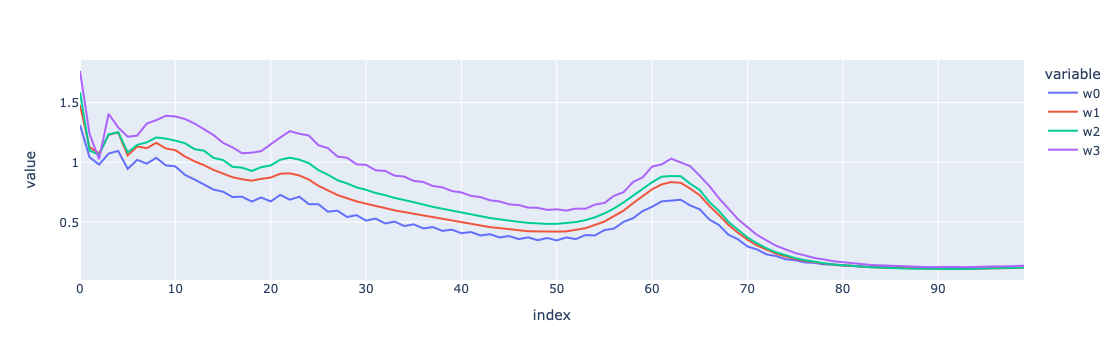

In [11]:
# the magnitude of the gradient at each training step

grad_norms = {
    'w0':[],
    'w1':[],
    'w2':[],
    'w3':[]
}
for grad_vector in grad_history:
    grad_norms['w0'].append(np.linalg.norm(grad_vector['w0'].flatten()))
    grad_norms['w1'].append(np.linalg.norm(grad_vector['w1'].flatten()))
    grad_norms['w2'].append(np.linalg.norm(grad_vector['w2'].flatten()))
    grad_norms['w3'].append(np.linalg.norm(grad_vector['w3'].flatten()))

fig = px.line(grad_norms)
fig.show()

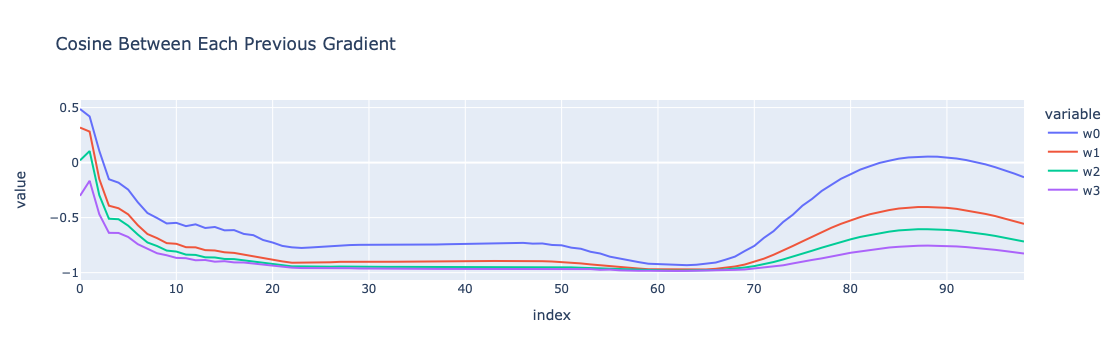

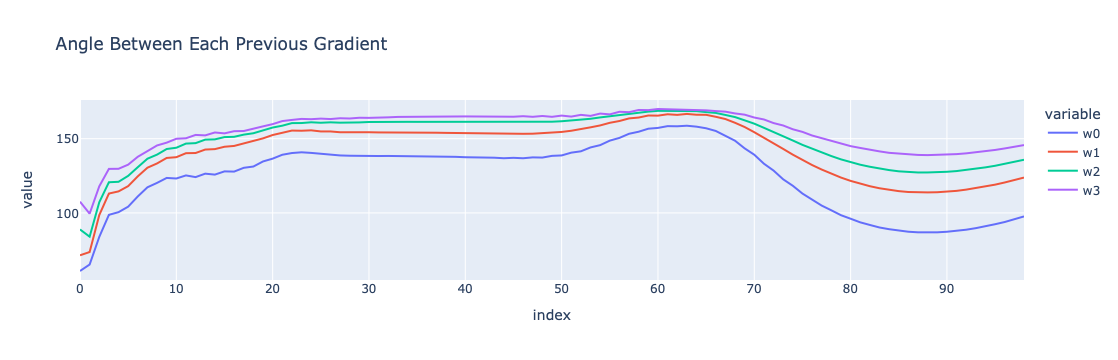

In [12]:
# for each training step, calculate the the angle between the current and previous vector

grad_cosines = {
    'w0':[],
    'w1':[],
    'w2':[],
    'w3':[]
}

grad_angles = {
    'w0':[],
    'w1':[],
    'w2':[],
    'w3':[]
}

for i in range(1,len(grad_history)):
    for key in ['w0','w1','w2','w3']:
        g_i = grad_history[i][key].flatten()
        g_i_norm = g_i / np.linalg.norm(g_i)
        g_im1 = grad_history[i-1][key].flatten()
        g_im1_norm = g_im1 / np.linalg.norm(g_im1)
        cos = g_i_norm @ g_im1_norm 
        grad_cosines[key].append(cos)
        angle = np.degrees(np.arccos(cos))
        grad_angles[key].append(angle)

fig_0 = px.line(grad_cosines, title="Cosine Between Each Previous Gradient")
fig_0.show()

fig_1 = px.line(grad_angles, title="Angle Between Each Previous Gradient")
fig_1.show()

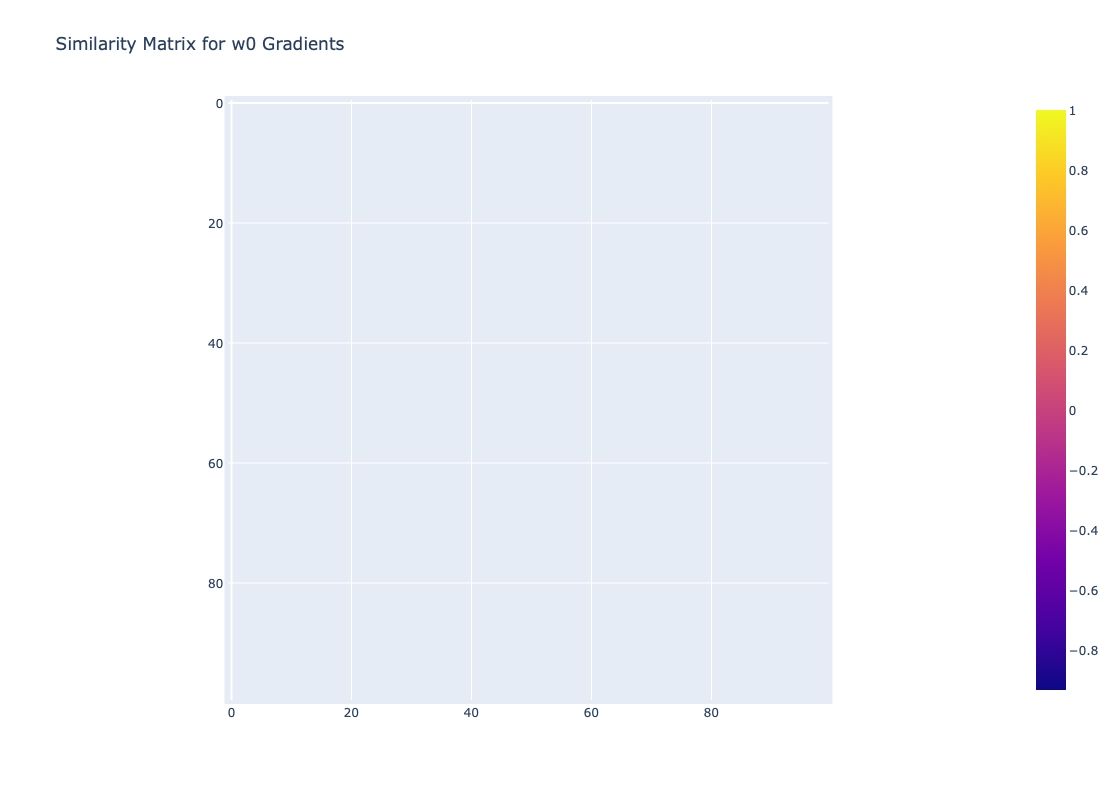

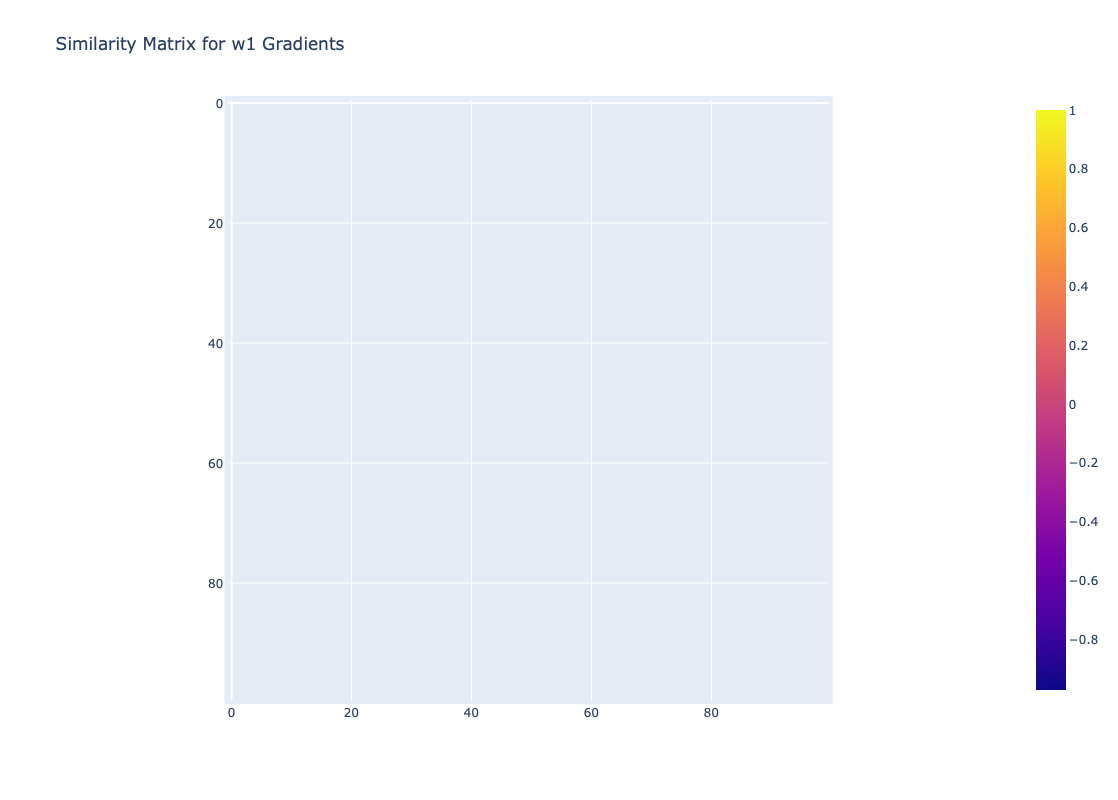

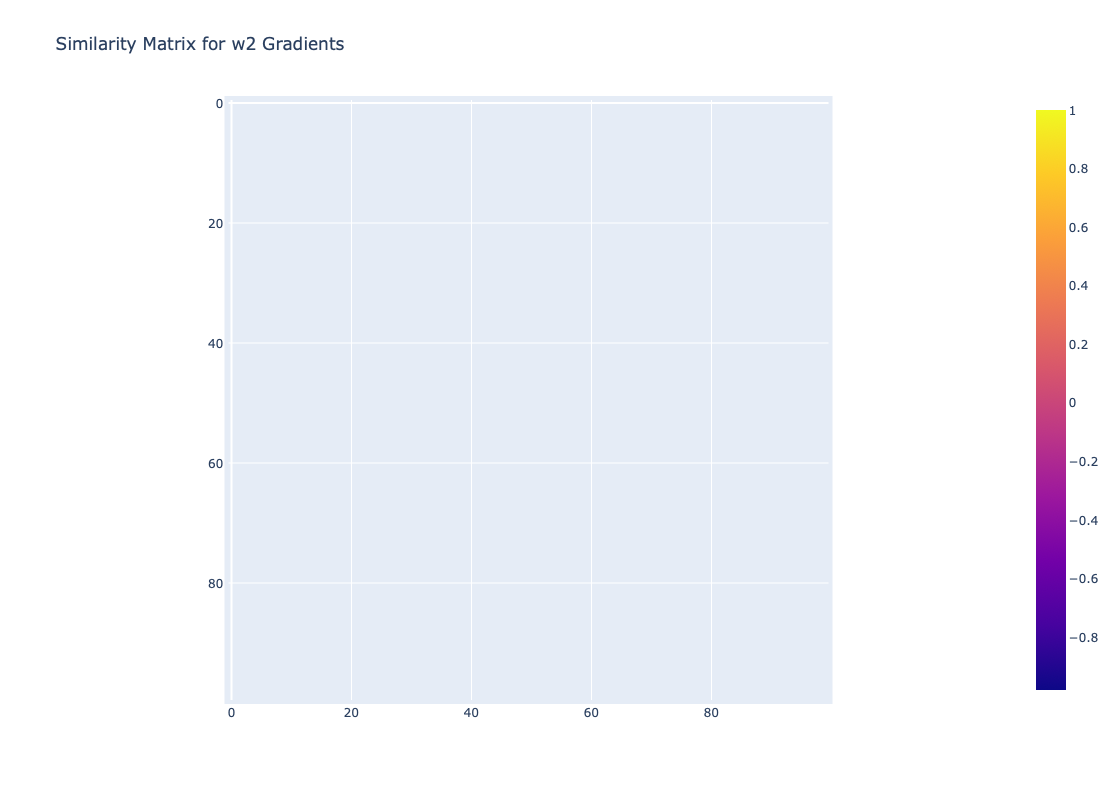

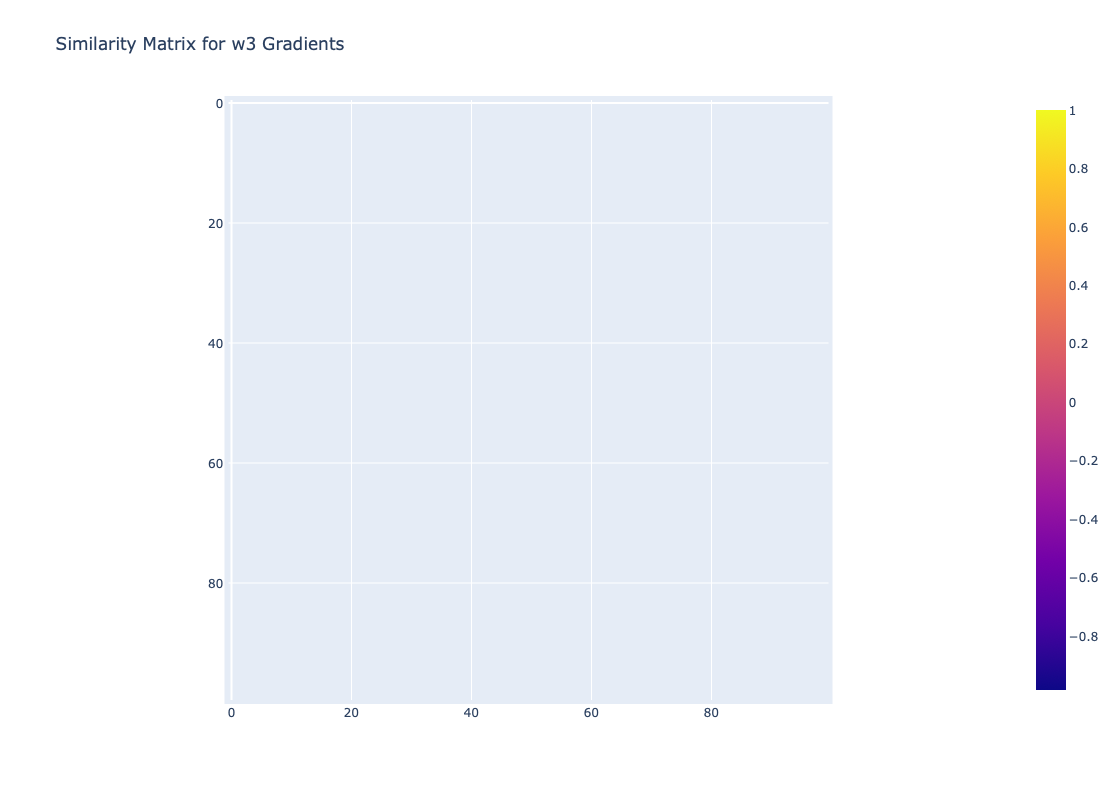

In [13]:
# Here we are going to find the similarity between each gradient, and each other gradient (per weight)
for key in ['w0','w1','w2','w3']:
    # The history of every gradient for this parameter during the training process
    history = [gradient_dict[key] for gradient_dict in grad_history]
    # convert from a list to an numpy array
    history = np.array(history)
    #print(history.shape) # should have a shape: (training_epochs, output_dim, input_dim)
    
    training_epochs, output_dim, input_dim = history.shape
    history = history.reshape(training_epochs, output_dim * input_dim)

    # normalize the gradient vector for each time step
    magnitudes = np.linalg.norm(history, axis=-1)
    history = (history.T / magnitudes).T

    # find the cosine of the angle between the gradient of each step, and each other step
    similarity_matrix = history @ history.T
    fig = px.imshow(similarity_matrix.reshape(100,100), title=f"Similarity Matrix for {key} Gradients")
    fig.update_layout(
        autosize=False,
        width=800,
        height=800,
        margin=dict(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        ),
    )
    fig.show()
    

# Visualizing the weight changes


We will use a process similar to stochastic neighbor embedding in which we will have $T$ vectors representing the changes that the weights undergo in each time step. We randomly create $T$ vectors in low dimensional space, and optimize them so that they have the most similar relative angles, and relative magnitudes as the changes in the training weights. 


In [14]:
parameter_deltas = np.array(parameter_deltas)

In [15]:
parameter_deltas.shape

(100, 334336)

In [16]:
def similarity_map(repr):
    magnitudes = jnp.linalg.norm(repr, axis=-1)
    repr = (repr.T / magnitudes).T
    return repr @ repr.T

In [17]:
# find the similarities between parameters, and other paramteters
parameter_similarities = similarity_map(parameter_deltas)

# find the magnitudes of each parameter change
parameter_delta_magnitudes = np.linalg.norm(parameter_deltas, axis=-1)

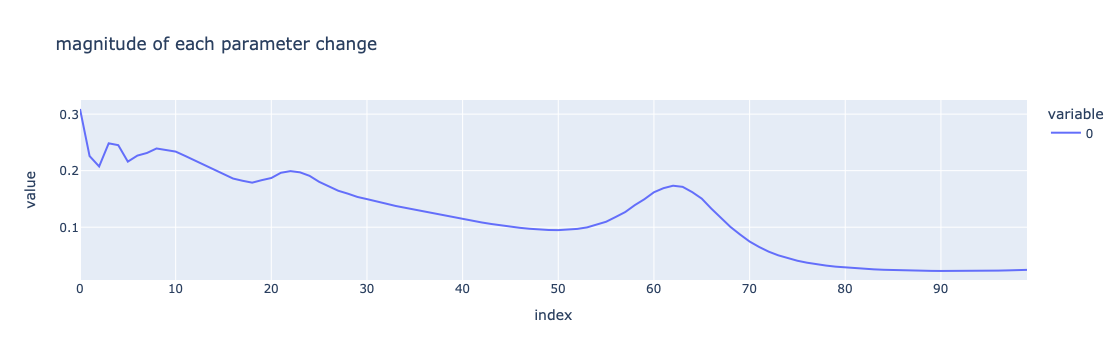

In [18]:
px.line(parameter_delta_magnitudes, title="magnitude of each parameter change").show()

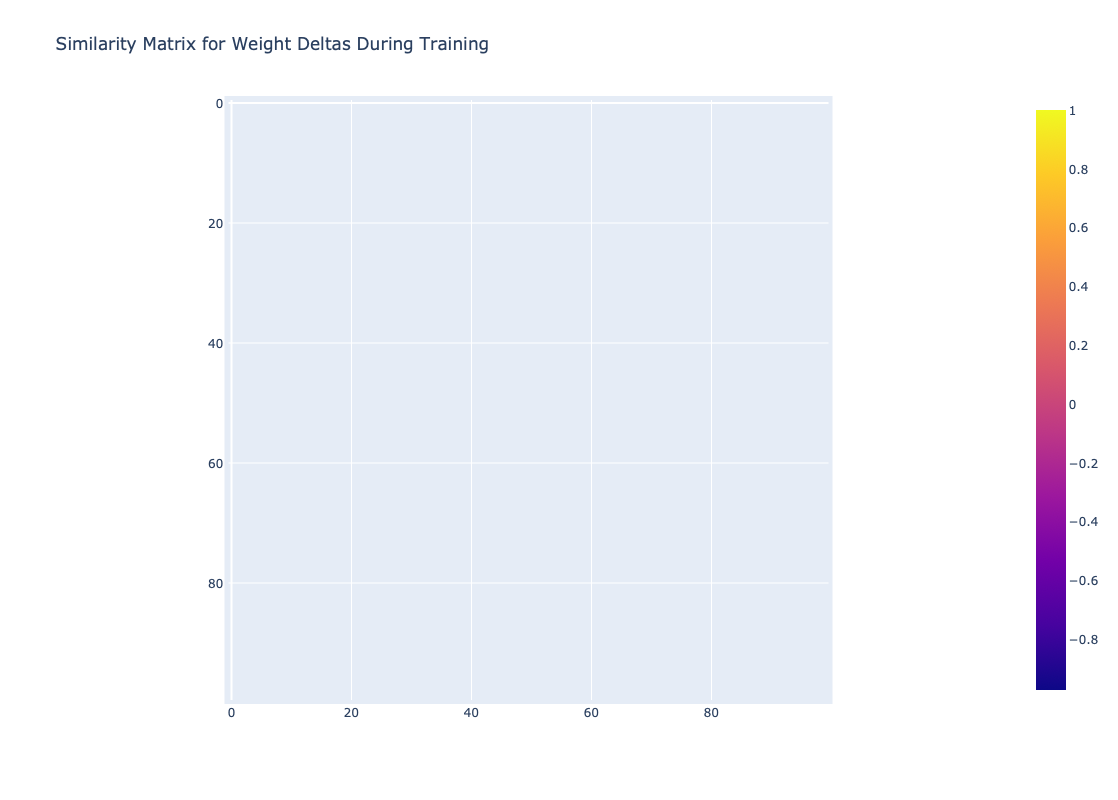

In [19]:

fig = px.imshow(parameter_similarities.reshape(100,100), title=f"Similarity Matrix for Weight Deltas During Training")
fig.update_layout(
        autosize=False,
        width=800,
        height=800,
        margin=dict(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        ),
    )
fig.show()

In [20]:
deltas = np.random.randn(100, 3) * 0.1 

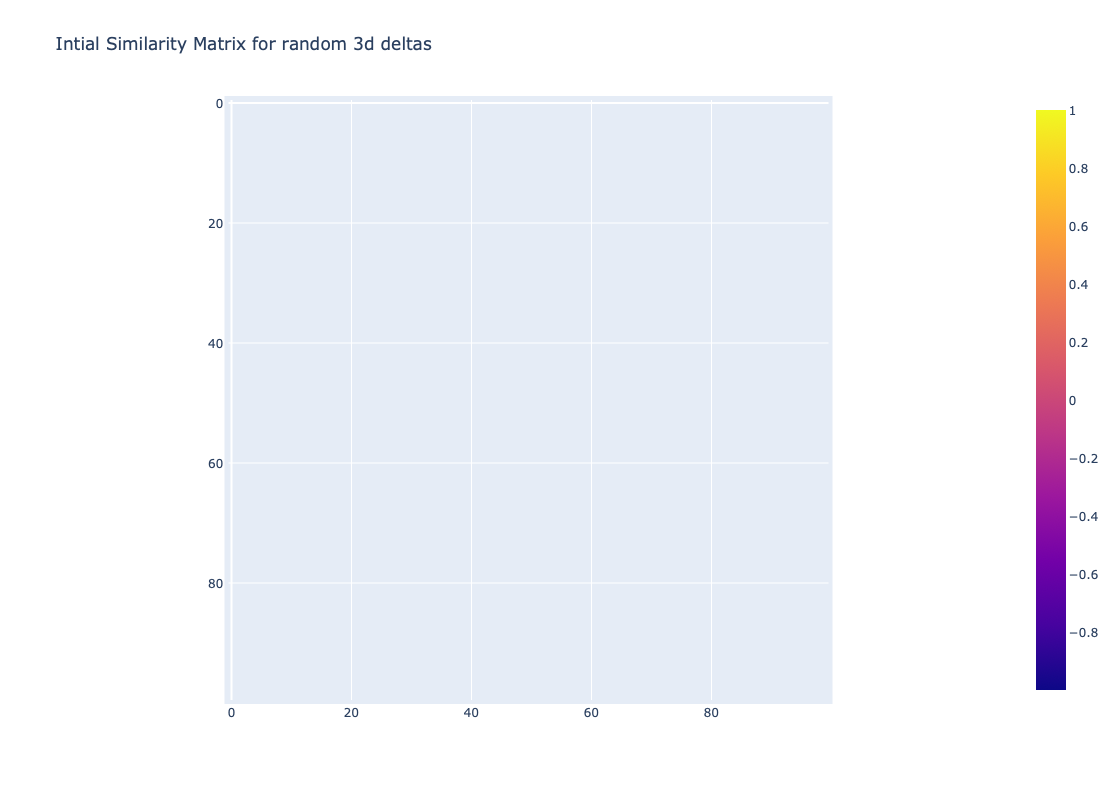

In [21]:
def visualize_delta_similarity_map(similarities, title=""):
    fig = px.imshow(similarities.reshape(100,100), title=title)
    fig.update_layout(
            autosize=False,
            width=800,
            height=800,
            margin=dict(
                l=50,
                r=50,
                b=100,
                t=100,
                pad=4
            ),
        )
    fig.show()
ld_similarities = similarity_map(deltas)
visualize_delta_similarity_map(ld_similarities, title="Intial Similarity Matrix for random 3d deltas")

In [22]:
def construct_points(deltas):
    # given a list of deltas, create points in space starting at the origin
    dim = deltas.shape[-1]
    points = [np.zeros(dim)]
    for delta in deltas: 
        last_point = points[-1]
        new_point = last_point + delta
        points.append(new_point)
    return np.array(points)

In [23]:
def calculate_distances(deltas):
    # given a list of deltas, find the total distance traveled along each point
    # find the distance that each delta goes
    magnitudes = np.linalg.norm(deltas, axis=-1)
    # find the distance traveled at each point
    distances = [magnitudes[:i].sum() for i in range(0, len(deltas))]
    return distances

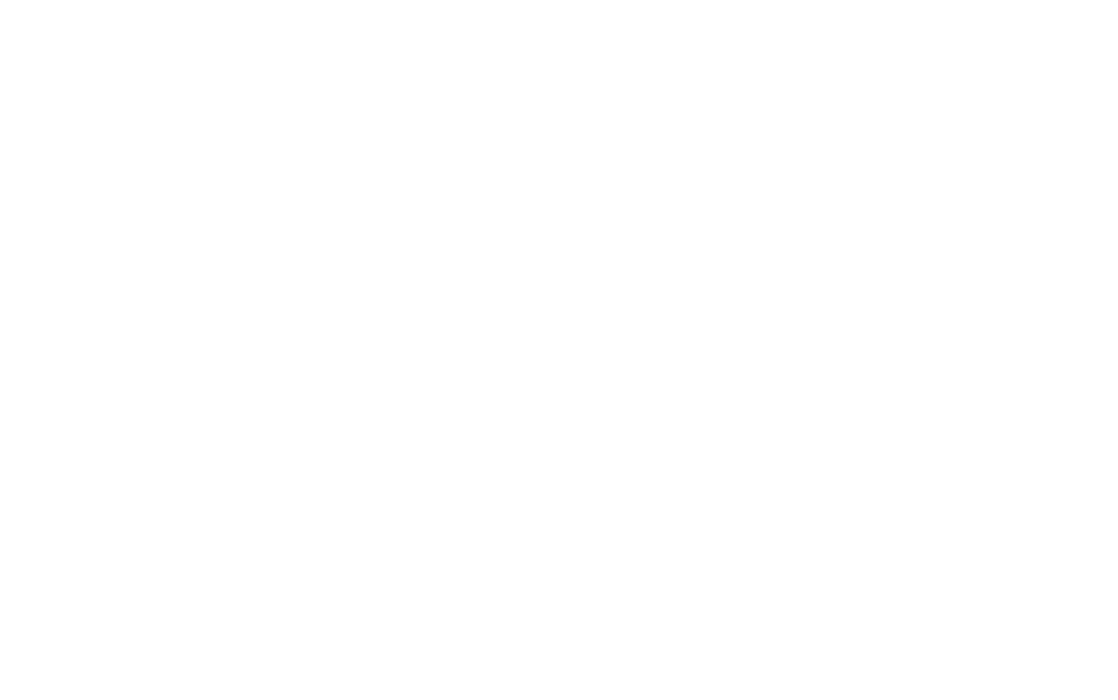

In [24]:
def visualize_deltas(deltas):
    points = construct_points(deltas)
    
    fig = go.Figure(data=go.Scatter3d(
        x=points[:,0], y=points[:,1], z=points[:,2],
        marker=dict(
            size=4,
            color=calculate_distances(deltas),
            colorscale='Viridis',
        ),
        line=dict(
            color='darkblue',
            width=2
        )
    ))
    
    fig.update_layout(
        width=800,
        height=700,
        autosize=False,
        scene=dict(
            camera=dict(
                up=dict(
                    x=0,
                    y=0,
                    z=1
                ),
                eye=dict(
                    x=0,
                    y=1.0707,
                    z=1,
                )
            ),
            aspectratio = dict( x=1, y=1, z=0.7 ),
            aspectmode = 'manual'
        ),
    )
    
    fig.show()

visualize_deltas(deltas)

In [25]:
def angle_similarity_loss(deltas):
    # compare the relative similarities between angles between deltas, and parameter deltas
    ld_similarities = similarity_map(deltas)
    difference = ld_similarities - parameter_similarities
    return (difference ** 2).mean()

angle_similarity_loss(deltas)

Array(0.6063774, dtype=float32)

In [26]:
def magnitude_similarity_loss(deltas):
    # compare the similarity between the magnitudes of the deltas, and the magnitudes of the parameter changes
    magnitudes = jnp.linalg.norm(deltas, axis=-1)
    return ((magnitudes - parameter_delta_magnitudes) ** 2).mean()

magnitude_similarity_loss(deltas)

Array(0.00914208, dtype=float32)

In [27]:
def total_loss(deltas):
    return magnitude_similarity_loss(deltas) + angle_similarity_loss(deltas)

total_loss(deltas)

Array(0.6155195, dtype=float32)

In [28]:
deltas = np.random.randn(100, 3) * 0.1 

In [29]:
for i in range(100):
    angle_similarity_grad_fn = jax.grad(angle_similarity_loss)
    grad = angle_similarity_grad_fn(deltas)
    deltas -= 0.5 * grad
    print(angle_similarity_loss(deltas))

0.5964816
0.5829333
0.5622697
0.5381429
0.50967044
0.47500637
0.4340699
0.39085728
0.34838098
0.3070019
0.2680783
0.2345094
0.207783
0.18676044
0.16971576
0.15537523
0.14294219
0.1319135
0.12195632
0.112854674
0.10449049
0.09683234
0.089912236
0.08378158
0.078463316
0.07392803
0.07010139
0.06688679
0.06418512
0.061906323
0.059973497
0.05832324
0.056903996
0.055674277
0.054600693
0.053656347
0.052819524
0.05207257
0.05140107
0.05079317
0.05023908
0.049730603
0.049260907
0.048824254
0.048415806
0.048031535
0.04766804
0.0473226
0.04699296
0.04667753
0.046374846
0.046084583
0.045805406
0.045538396
0.045280438
0.04503451
0.044792477
0.04456093
0.04432836
0.04410638
0.043886006
0.04367704
0.0434731
0.0432785
0.043088365
0.04290485
0.04272402
0.042547736
0.04237282
0.042200852
0.04202944
0.041859604
0.04168965
0.041520078
0.041349847
0.041179154
0.04100745
0.040834904
0.040661335
0.04048702
0.040312037
0.04013674
0.03996139
0.03978637
0.03961198
0.039438535
0.03926626
0.039095327
0.038925815


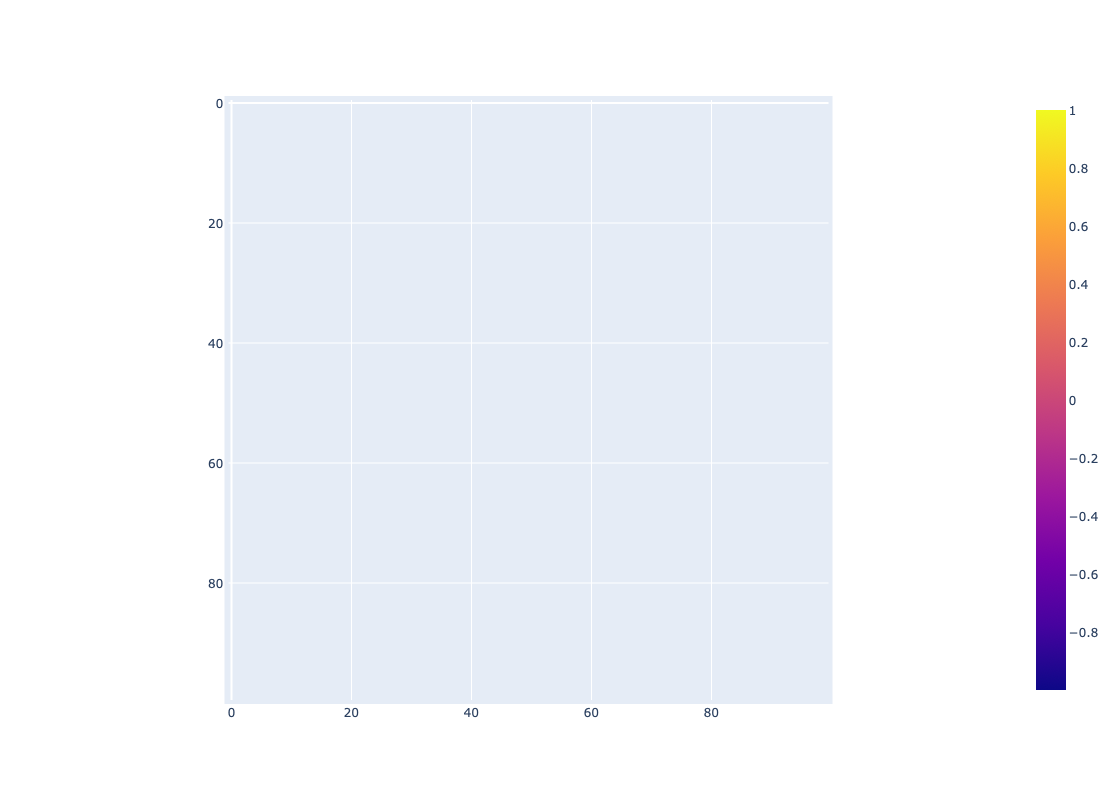

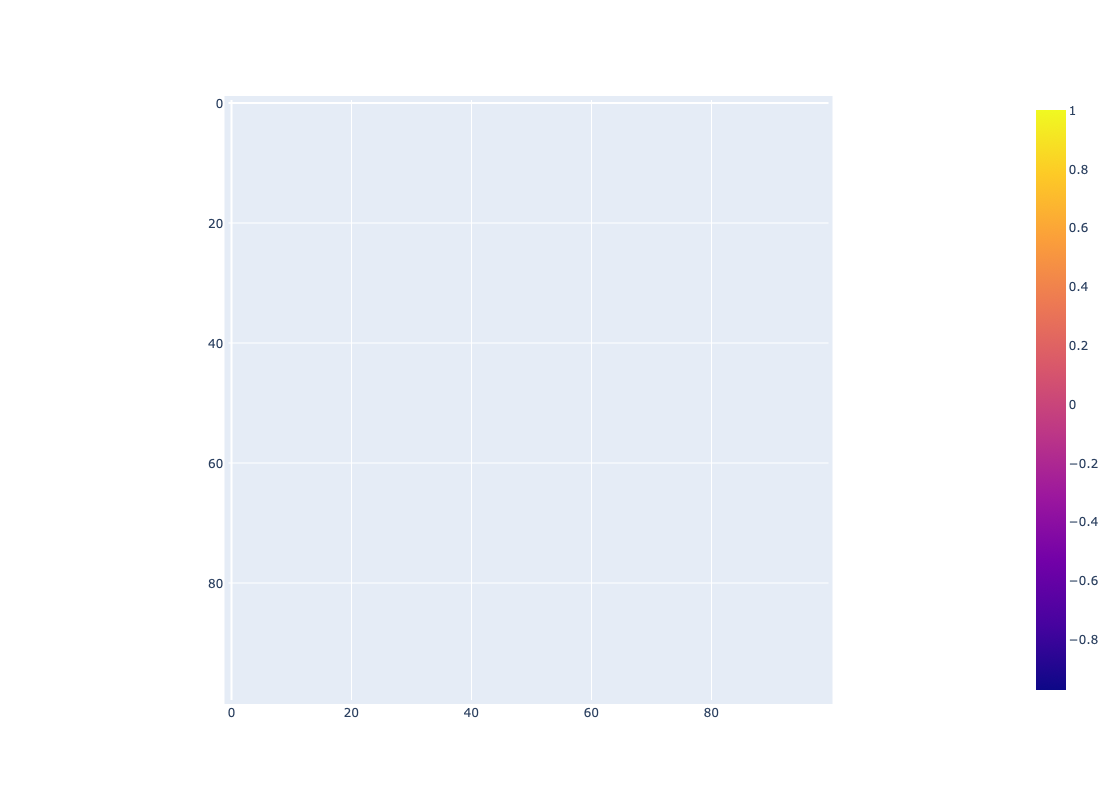

In [30]:
visualize_delta_similarity_map(similarity_map(deltas))
visualize_delta_similarity_map(parameter_similarities)

In [31]:
def magnitude_update(deltas):
    # change the deltas to have the same magnitudes as the corresponding weight updates
    normalized_deltas = (deltas.T / np.linalg.norm(deltas, axis=-1)).T
    return np.array([delta * parameter_delta_magnitudes[i] for i, delta in enumerate(deltas)])

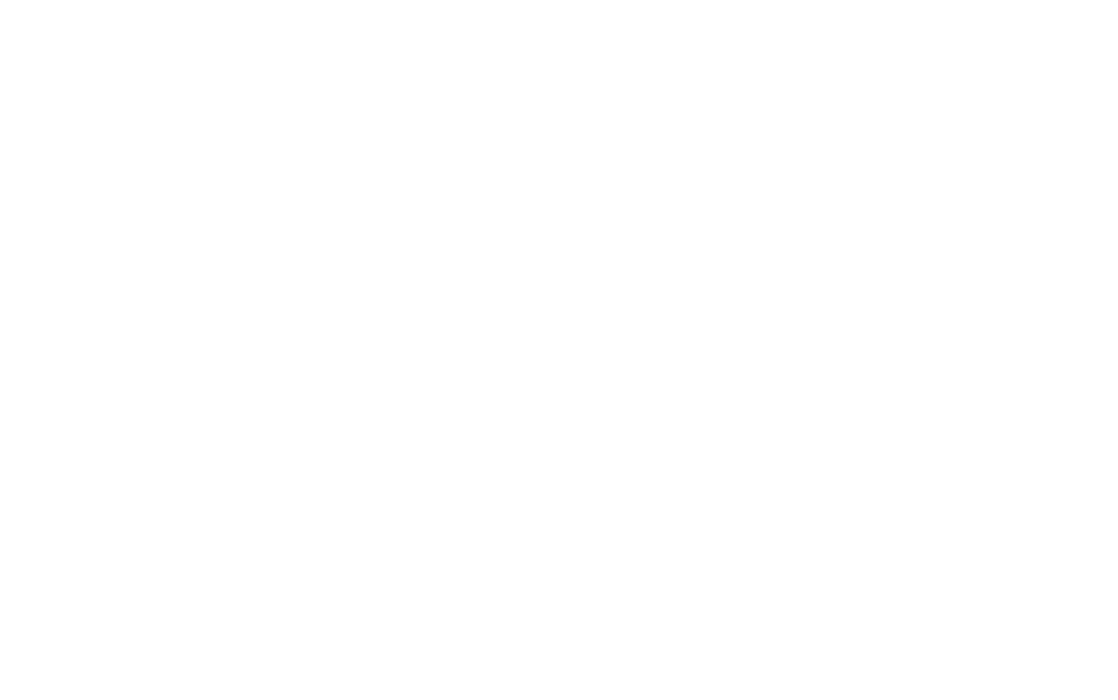

In [32]:
visualize_deltas(magnitude_update(deltas))

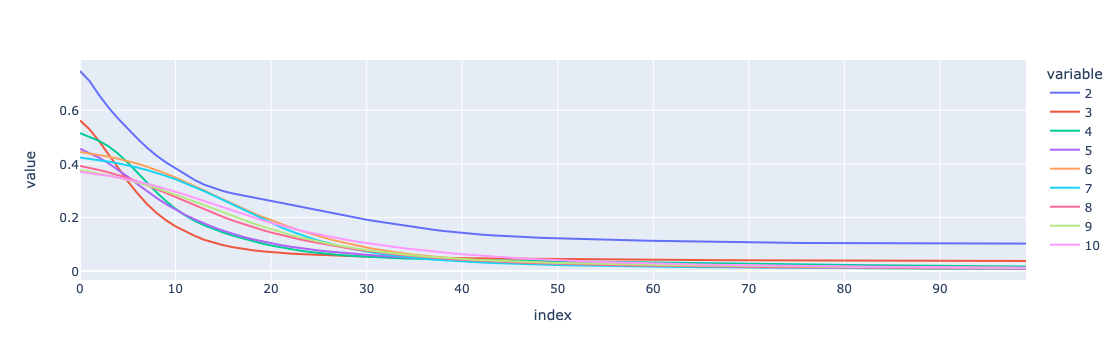

In [33]:
delta_opt_history = {}
for dim in range(2, 11):

    deltas = np.random.randn(100, dim) * 0.1
    history = []
    
    for i in range(100):
        angle_similarity_grad_fn = jax.grad(angle_similarity_loss)
        grad = angle_similarity_grad_fn(deltas)
        deltas -= 0.5 * grad
        error = angle_similarity_loss(deltas)
        history.append(error)
    delta_opt_history[f"{dim}"] = history
    
px.line(delta_opt_history).show() 

## Example Gradient Descent for a simple function

In [37]:
def _L(d):
    return (0.7*d[:,:,0])**2 + d[:,:,1]**2
def L(d):
    return (0.7*d[0])**2 + (d[1])**2

x = np.arange(-10, 10, 0.5)
y = np.arange(-10, 10, 0.5)
X,Y = np.meshgrid(x,y)
X = np.expand_dims(X,axis=-1)
Y = np.expand_dims(Y,axis=-1)
domain = np.concatenate([X,Y],axis=-1)

Z = _L(domain)
Z.shape

(40, 40)

In [38]:
parameters = np.array([8.0,8.0])
loss_grad = jax.grad(L)
point_history = [np.concatenate([parameters, [L(parameters)]])]
for i in range(10):
    parameters -= 0.2 * loss_grad(parameters)
    point_history.append(np.concatenate([parameters, [L(parameters)+0.1]]))
point_history = np.array(point_history)

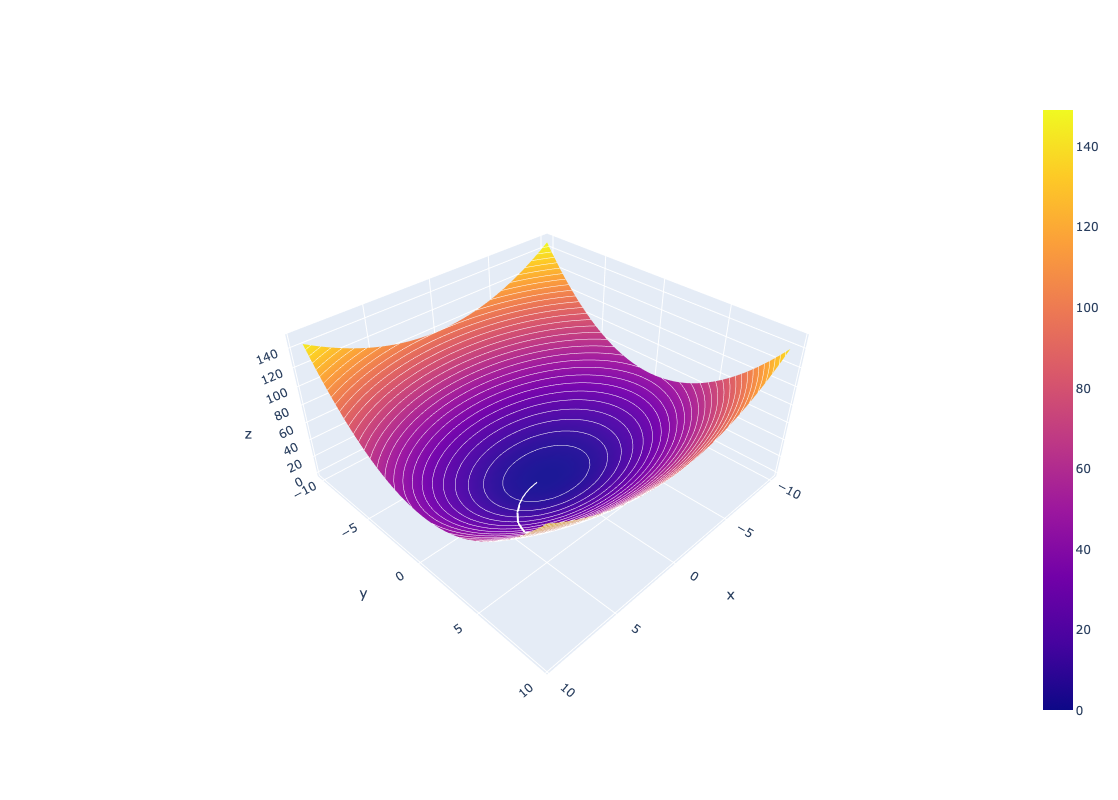

In [39]:
fig = go.Figure(go.Surface(
    contours = {
        "z": {"show": True, "start": 0, "end": 200, "size": 5, "color":"white"},
    },
    x = x,
    y = y,
    z = Z
))
line_marker = dict(color='#ffffff', width=4)
fig.add_scatter3d(x=point_history[:,0], y=point_history[:,1], z=point_history[:,2], mode='lines', line=line_marker, name='')
fig.update_layout(
            autosize=False,
            width=800,
            height=800,
            
        )
fig.update_layout(
        scene = {
            "aspectratio": {"x": 1, "y": 1, "z": 0.5}
        })
fig.show()